In [0]:

# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pip install catboost

### Load packages

In [0]:
# Libraries
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime
import lightgbm as lgb
from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
import keras.models
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout

import os
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import xgboost as xgb
import lightgbm as lgb
from sklearn import model_selection
from sklearn.metrics import accuracy_score, roc_auc_score,classification_report
from sklearn import metrics
import json
import ast
import time
from sklearn import linear_model
from imblearn import under_sampling, over_sampling, combine
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.over_sampling import SMOTE, ADASYN


from tqdm import tqdm_notebook
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_selection import GenericUnivariateSelect, SelectPercentile, SelectKBest, f_classif, mutual_info_classif, RFE
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
from catboost import CatBoostClassifier
from statistics import mean 
import gc

# import json
import altair as alt
# from  altair.vega import v3
from IPython.display import HTML

from plotly import tools
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import warnings
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

In [0]:

!ls '/content/drive/My Drive/AV_data/India_ML_Hiring_Hack_24082019'


sample_submission.csv  test.csv  train.csv


### Read the datasets

In [0]:
file = r'/content/drive/My Drive/AV_data/India_ML_Hiring_Hack_24082019/'
train_df = pd.read_csv(file+'train.csv')
test_df = pd.read_csv(file+'test.csv')
submission_df = pd.read_csv(file+'sample_submission.csv')

In [0]:
train_df.head()

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13
0,268055008619,Z,"Turner, Baldwin and Rhodes",4.250,214000,360,2012-03-01,05/2012,95,1.0,22.0,694.0,C86,30.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,672831657627,Y,"Swanson, Newton and Miller",4.875,144000,360,2012-01-01,03/2012,72,1.0,44.0,697.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,1
2,742515242108,Z,Thornton-Davis,3.250,366000,180,2012-01-01,03/2012,49,1.0,33.0,780.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,601385667462,X,OTHER,4.750,135000,360,2012-02-01,04/2012,46,2.0,44.0,633.0,B12,0.0,638.0,0.0,0,0,0,0,0,0,0,0,1,1,1,1,1
4,273870029961,X,OTHER,4.750,124000,360,2012-02-01,04/2012,80,1.0,43.0,681.0,C86,0.0,0.0,0.0,0,1,2,3,4,5,6,7,8,9,10,11,1


In [0]:
test_df.head()

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
0,1,Y,Browning-Hart,3.875,417000,360,01/02/12,Apr-12,75,1,20,790,A23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,X,OTHER,4.500,113000,360,01/02/12,Apr-12,80,2,33,793,C86,0,784,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,Y,OTHER,4.500,72000,360,01/01/12,Mar-12,75,1,34,710,C86,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,X,"Miller, Mcclure and Allen",4.125,123000,180,01/02/12,Apr-12,41,2,24,798,A23,0,813,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,X,Browning-Hart,3.250,166000,180,01/02/12,Apr-12,53,2,12,767,A23,0,768,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
submission_df.head()

,loan_id,m13
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [0]:
print(f'Number of samples in train: {train_df.shape[0]}')
print(f'Number of columns in train: {train_df.shape[1]}')
for col in train_df.columns:
    if train_df[col].isnull().any():
        print(col, train_df[col].isnull().sum())


Number of samples in train: 116058
Number of columns in train: 29


In [0]:
print(f'Number of samples in test: {test_df.shape[0]}')
print(f'Number of columns in test: {test_df.shape[1]}')
for col in test_df.columns:
    if test_df[col].isnull().any():
        print(col, test_df[col].isnull().sum())

Number of samples in test: 35866
Number of columns in test: 28


### Univariate Analysis

We will first look at the target variable, i.e., m13. As it is a categorical variable, let us look at its frequency table, percentage distribution and bar plot.

Frequency table of a variable will give us the count of each category in that variable.

In [0]:
train_df.columns

Index(['loan_id', 'source', 'financial_institution', 'interest_rate',
       'unpaid_principal_bal', 'loan_term', 'origination_date',
       'first_payment_date', 'loan_to_value', 'number_of_borrowers',
       'debt_to_income_ratio', 'borrower_credit_score', 'loan_purpose',
       'insurance_percent', 'co-borrower_credit_score', 'insurance_type', 'm1',
       'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12',
       'm13'],
      dtype='object')

In [0]:
train_df['m13'].value_counts()

0    115422
1       636
Name: m13, dtype: int64

In [0]:
# Normalise can be set to true to print the proportions instead of Numbers.
train_df['m13'].value_counts(normalize=True)

0    0.99452
1    0.00548
Name: m13, dtype: float64

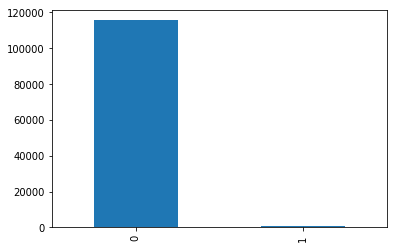

In [0]:
train_df['m13'].value_counts().plot.bar()

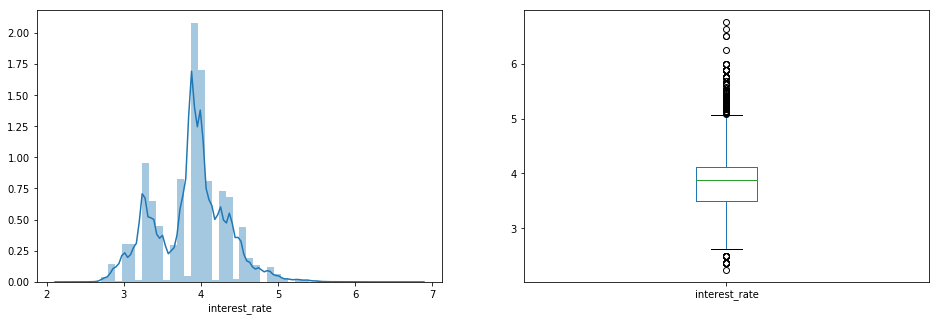

In [0]:
plt.figure(1)
plt.subplot(121)
sns.distplot((train_df['interest_rate']));

plt.subplot(122)
(train_df['interest_rate']).plot.box(figsize=(16,5))
plt.show()

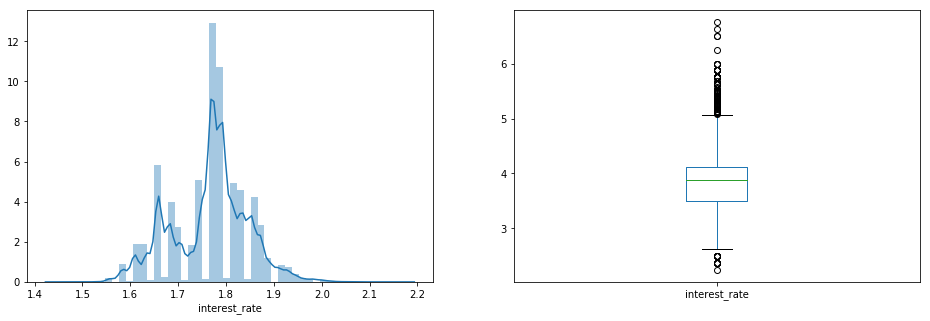

In [0]:
plt.figure(1)
plt.subplot(121)
sns.distplot((np.log1p(train_df['interest_rate']+1)));

plt.subplot(122)
(train_df['interest_rate']).plot.box(figsize=(16,5))
plt.show()

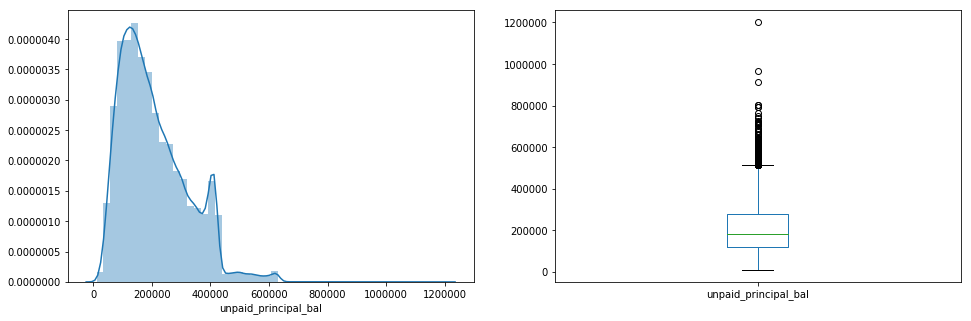

In [0]:
plt.figure(1)
plt.subplot(121)
sns.distplot((train_df['unpaid_principal_bal']));

plt.subplot(122)
(train_df['unpaid_principal_bal']).plot.box(figsize=(16,5))
plt.show()

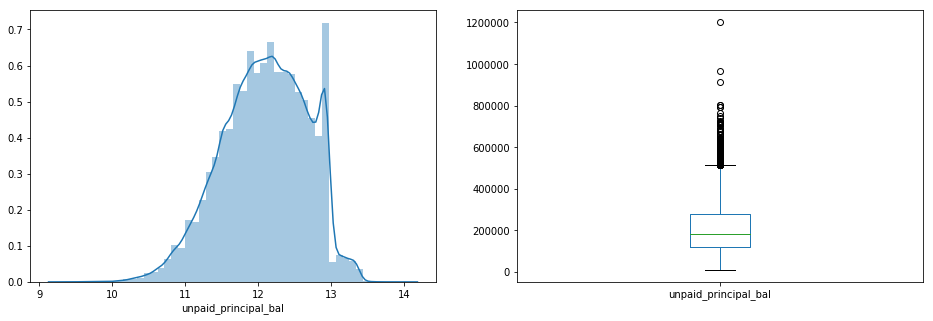

In [0]:
plt.figure(1)
plt.subplot(121)
sns.distplot((np.log1p(train_df['unpaid_principal_bal']+1)));

plt.subplot(122)
(train_df['unpaid_principal_bal']).plot.box(figsize=(16,5))
plt.show()

In [0]:
# train_df['log_unpaid_principal_bal'] = np.log1p(train_df['unpaid_principal_bal']+1)
# test_df['log_unpaid_principal_bal'] = np.log1p(test_df['unpaid_principal_bal']+1)

In [0]:
# train_df.drop(['unpaid_principal_bal'],axis=1,inplace=True)
# test_df.drop(['unpaid_principal_bal'],axis=1,inplace=True)

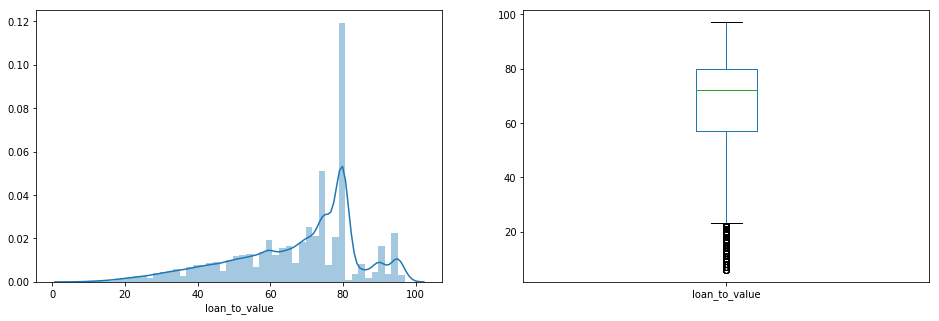

In [0]:
plt.figure(1)
plt.subplot(121)
sns.distplot((train_df['loan_to_value']));

plt.subplot(122)
(train_df['loan_to_value']).plot.box(figsize=(16,5))
plt.show()

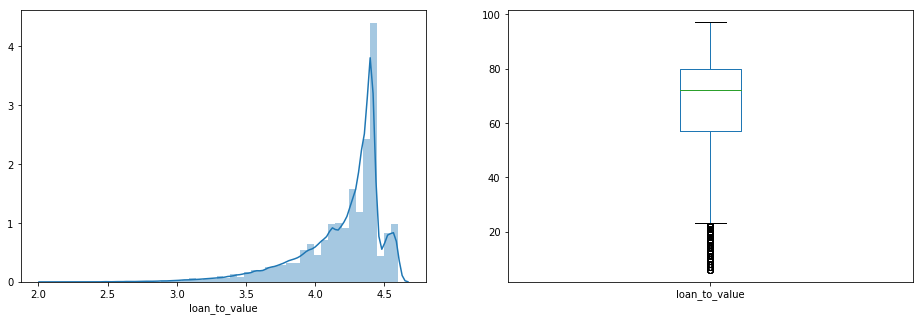

In [0]:
plt.figure(1)
plt.subplot(121)
sns.distplot((np.log1p(train_df['loan_to_value']+1)));

plt.subplot(122)
(train_df['loan_to_value']).plot.box(figsize=(16,5))
plt.show()

In [0]:
train_df.dtypes

loan_id                       int64
source                       object
financial_institution        object
interest_rate               float64
unpaid_principal_bal          int64
loan_term                     int64
origination_date             object
first_payment_date           object
loan_to_value                 int64
number_of_borrowers         float64
debt_to_income_ratio        float64
borrower_credit_score       float64
loan_purpose                 object
insurance_percent           float64
co-borrower_credit_score    float64
insurance_type              float64
m1                            int64
m2                            int64
m3                            int64
m4                            int64
m5                            int64
m6                            int64
m7                            int64
m8                            int64
m9                            int64
m10                           int64
m11                           int64
m12                         

In [0]:
train_df.head()

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13
0,268055008619,Z,"Turner, Baldwin and Rhodes",4.250,214000,360,2012-03-01,05/2012,95,1.0,22.0,694.0,C86,30.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,672831657627,Y,"Swanson, Newton and Miller",4.875,144000,360,2012-01-01,03/2012,72,1.0,44.0,697.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,1
2,742515242108,Z,Thornton-Davis,3.250,366000,180,2012-01-01,03/2012,49,1.0,33.0,780.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,601385667462,X,OTHER,4.750,135000,360,2012-02-01,04/2012,46,2.0,44.0,633.0,B12,0.0,638.0,0.0,0,0,0,0,0,0,0,0,1,1,1,1,1
4,273870029961,X,OTHER,4.750,124000,360,2012-02-01,04/2012,80,1.0,43.0,681.0,C86,0.0,0.0,0.0,0,1,2,3,4,5,6,7,8,9,10,11,1


In [0]:
train_df['source'].value_counts()

X    63858
Y    37554
Z    14646
Name: source, dtype: int64

In [0]:
test_df['source'].value_counts()

X    19714
Y    11653
Z     4499
Name: source, dtype: int64

In [0]:
train_df['financial_institution'].value_counts()

OTHER                          49699
Browning-Hart                  31852
Swanson, Newton and Miller      6874
Edwards-Hoffman                 4857
Martinez, Duffy and Bird        4715
Miller, Mcclure and Allen       3158
Nicholson Group                 2116
Turner, Baldwin and Rhodes      1846
Suarez Inc                      1790
Cole, Brooks and Vincent        1642
Richards-Walters                1459
Taylor, Hunt and Rodriguez      1259
Sanchez-Robinson                1193
Sanchez, Hays and Wilkerson      853
Romero, Woods and Johnson        750
Thornton-Davis                   651
Anderson-Taylor                  483
Richardson Ltd                   473
Chapman-Mcmahon                  388
Name: financial_institution, dtype: int64

In [0]:
test_df['financial_institution'].value_counts()

OTHER                          15162
Browning-Hart                  10078
Swanson, Newton and Miller      2095
Edwards-Hoffman                 1530
Martinez, Duffy and Bird        1448
Miller, Mcclure and Allen        912
Nicholson Group                  596
Suarez Inc                       586
Turner, Baldwin and Rhodes       542
Cole, Brooks and Vincent         492
Richards-Walters                 462
Taylor, Hunt and Rodriguez       397
Sanchez-Robinson                 384
Sanchez, Hays and Wilkerson      289
Romero, Woods and Johnson        241
Thornton-Davis                   216
Richardson Ltd                   170
Anderson-Taylor                  152
Chapman-Mcmahon                  114
Name: financial_institution, dtype: int64

In [0]:
train_df['loan_purpose'].value_counts()

A23    58462
B12    29383
C86    28213
Name: loan_purpose, dtype: int64

In [0]:
test_df['loan_purpose'].value_counts()

A23    17892
B12     9197
C86     8777
Name: loan_purpose, dtype: int64

In [0]:
train_df.dtypes

loan_id                       int64
source                       object
financial_institution        object
interest_rate               float64
unpaid_principal_bal          int64
loan_term                     int64
origination_date             object
first_payment_date           object
loan_to_value                 int64
number_of_borrowers         float64
debt_to_income_ratio        float64
borrower_credit_score       float64
loan_purpose                 object
insurance_percent           float64
co-borrower_credit_score    float64
insurance_type              float64
m1                            int64
m2                            int64
m3                            int64
m4                            int64
m5                            int64
m6                            int64
m7                            int64
m8                            int64
m9                            int64
m10                           int64
m11                           int64
m12                         

In [0]:
train_df.head()

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13
0,268055008619,Z,"Turner, Baldwin and Rhodes",4.250,214000,360,2012-03-01,05/2012,95,1.0,22.0,694.0,C86,30.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,672831657627,Y,"Swanson, Newton and Miller",4.875,144000,360,2012-01-01,03/2012,72,1.0,44.0,697.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,1
2,742515242108,Z,Thornton-Davis,3.250,366000,180,2012-01-01,03/2012,49,1.0,33.0,780.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,601385667462,X,OTHER,4.750,135000,360,2012-02-01,04/2012,46,2.0,44.0,633.0,B12,0.0,638.0,0.0,0,0,0,0,0,0,0,0,1,1,1,1,1
4,273870029961,X,OTHER,4.750,124000,360,2012-02-01,04/2012,80,1.0,43.0,681.0,C86,0.0,0.0,0.0,0,1,2,3,4,5,6,7,8,9,10,11,1


In [0]:
test_df.dtypes

loan_id                       int64
source                       object
financial_institution        object
interest_rate               float64
unpaid_principal_bal          int64
loan_term                     int64
origination_date             object
first_payment_date           object
loan_to_value                 int64
number_of_borrowers           int64
debt_to_income_ratio          int64
borrower_credit_score         int64
loan_purpose                 object
insurance_percent             int64
co-borrower_credit_score      int64
insurance_type                int64
m1                            int64
m2                            int64
m3                            int64
m4                            int64
m5                            int64
m6                            int64
m7                            int64
m8                            int64
m9                            int64
m10                           int64
m11                           int64
m12                         

In [0]:
train_df.head()

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13
0,268055008619,Z,"Turner, Baldwin and Rhodes",4.250,214000,360,2012-03-01,05/2012,95,1.0,22.0,694.0,C86,30.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,672831657627,Y,"Swanson, Newton and Miller",4.875,144000,360,2012-01-01,03/2012,72,1.0,44.0,697.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,1
2,742515242108,Z,Thornton-Davis,3.250,366000,180,2012-01-01,03/2012,49,1.0,33.0,780.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,601385667462,X,OTHER,4.750,135000,360,2012-02-01,04/2012,46,2.0,44.0,633.0,B12,0.0,638.0,0.0,0,0,0,0,0,0,0,0,1,1,1,1,1
4,273870029961,X,OTHER,4.750,124000,360,2012-02-01,04/2012,80,1.0,43.0,681.0,C86,0.0,0.0,0.0,0,1,2,3,4,5,6,7,8,9,10,11,1


In [0]:
train_df.head()

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13
0,268055008619,Z,"Turner, Baldwin and Rhodes",4.250,214000,360,2012-03-01,05/2012,95,1.0,22.0,694.0,C86,30.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,672831657627,Y,"Swanson, Newton and Miller",4.875,144000,360,2012-01-01,03/2012,72,1.0,44.0,697.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,1
2,742515242108,Z,Thornton-Davis,3.250,366000,180,2012-01-01,03/2012,49,1.0,33.0,780.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,601385667462,X,OTHER,4.750,135000,360,2012-02-01,04/2012,46,2.0,44.0,633.0,B12,0.0,638.0,0.0,0,0,0,0,0,0,0,0,1,1,1,1,1
4,273870029961,X,OTHER,4.750,124000,360,2012-02-01,04/2012,80,1.0,43.0,681.0,C86,0.0,0.0,0.0,0,1,2,3,4,5,6,7,8,9,10,11,1


In [0]:
train_df.isnull().sum()

loan_id                     0
source                      0
financial_institution       0
interest_rate               0
unpaid_principal_bal        0
loan_term                   0
origination_date            0
first_payment_date          0
loan_to_value               0
number_of_borrowers         0
debt_to_income_ratio        0
borrower_credit_score       0
loan_purpose                0
insurance_percent           0
co-borrower_credit_score    0
insurance_type              0
m1                          0
m2                          0
m3                          0
m4                          0
m5                          0
m6                          0
m7                          0
m8                          0
m9                          0
m10                         0
m11                         0
m12                         0
m13                         0
dtype: int64

In [0]:
test_df.isnull().sum()

loan_id                     0
source                      0
financial_institution       0
interest_rate               0
unpaid_principal_bal        0
loan_term                   0
origination_date            0
first_payment_date          0
loan_to_value               0
number_of_borrowers         0
debt_to_income_ratio        0
borrower_credit_score       0
loan_purpose                0
insurance_percent           0
co-borrower_credit_score    0
insurance_type              0
m1                          0
m2                          0
m3                          0
m4                          0
m5                          0
m6                          0
m7                          0
m8                          0
m9                          0
m10                         0
m11                         0
m12                         0
dtype: int64

In [0]:
test_df.head()

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
0,1,Y,Browning-Hart,3.875,417000,360,01/02/12,Apr-12,75,1,20,790,A23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,X,OTHER,4.500,113000,360,01/02/12,Apr-12,80,2,33,793,C86,0,784,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,Y,OTHER,4.500,72000,360,01/01/12,Mar-12,75,1,34,710,C86,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,X,"Miller, Mcclure and Allen",4.125,123000,180,01/02/12,Apr-12,41,2,24,798,A23,0,813,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,X,Browning-Hart,3.250,166000,180,01/02/12,Apr-12,53,2,12,767,A23,0,768,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
a = test_df["origination_date"].str.split("/", n = 2, expand = True) 

In [0]:
test_df["origination_date_month"] = a[1]

In [0]:
test_df.head()

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,origination_date_month
0,1,Y,Browning-Hart,3.875,417000,360,01/02/12,Apr-12,75,1,20,790,A23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,02
1,2,X,OTHER,4.500,113000,360,01/02/12,Apr-12,80,2,33,793,C86,0,784,0,0,0,0,0,0,0,0,0,0,0,0,0,02
2,3,Y,OTHER,4.500,72000,360,01/01/12,Mar-12,75,1,34,710,C86,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,01
3,4,X,"Miller, Mcclure and Allen",4.125,123000,180,01/02/12,Apr-12,41,2,24,798,A23,0,813,0,0,0,0,0,0,0,0,0,0,0,0,0,02
4,5,X,Browning-Hart,3.250,166000,180,01/02/12,Apr-12,53,2,12,767,A23,0,768,0,0,0,0,0,0,0,0,0,0,0,0,0,02


In [0]:
b = test_df["first_payment_date"].str.split("-", n = 1, expand = True)

In [0]:
b.head()

,0,1
0,Apr,12
1,Apr,12
2,Mar,12
3,Apr,12
4,Apr,12


In [0]:
b.columns = ['Month', 'Year']

In [0]:
b.head()

,Month,Year
0,Apr,12
1,Apr,12
2,Mar,12
3,Apr,12
4,Apr,12


In [0]:
b['Month'].value_counts()

Apr    16551
Mar    14661
May     4510
Feb      144
Name: Month, dtype: int64

In [0]:
dict = {'Feb': 2, 'Mar' : 3, 'Apr' : 4, 'May' : 5}
# Remap the values of the dataframe 
b.replace({"Month": dict},inplace=True)

In [0]:
b.head()

,Month,Year
0,4,12
1,4,12
2,3,12
3,4,12
4,4,12


In [0]:
test_df['first_payment_date_month'] = b['Month']

In [0]:
test_df.head()

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,origination_date_month,first_payment_date_month
0,1,Y,Browning-Hart,3.875,417000,360,01/02/12,Apr-12,75,1,20,790,A23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,02,4
1,2,X,OTHER,4.500,113000,360,01/02/12,Apr-12,80,2,33,793,C86,0,784,0,0,0,0,0,0,0,0,0,0,0,0,0,02,4
2,3,Y,OTHER,4.500,72000,360,01/01/12,Mar-12,75,1,34,710,C86,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,01,3
3,4,X,"Miller, Mcclure and Allen",4.125,123000,180,01/02/12,Apr-12,41,2,24,798,A23,0,813,0,0,0,0,0,0,0,0,0,0,0,0,0,02,4
4,5,X,Browning-Hart,3.250,166000,180,01/02/12,Apr-12,53,2,12,767,A23,0,768,0,0,0,0,0,0,0,0,0,0,0,0,0,02,4


In [0]:
test_df['origination_date_month'] = test_df['origination_date_month'].apply(lambda x: int(x))
test_df['first_payment_date_month'] = test_df['first_payment_date_month'].apply(lambda x: int(x))

In [0]:
# test_df['diff_payment_months'] = test_df['first_payment_date_month'] - test_df['origination_date_month']

In [0]:
test_df.head()

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,origination_date_month,first_payment_date_month
0,1,Y,Browning-Hart,3.875,417000,360,01/02/12,Apr-12,75,1,20,790,A23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,4
1,2,X,OTHER,4.500,113000,360,01/02/12,Apr-12,80,2,33,793,C86,0,784,0,0,0,0,0,0,0,0,0,0,0,0,0,2,4
2,3,Y,OTHER,4.500,72000,360,01/01/12,Mar-12,75,1,34,710,C86,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3
3,4,X,"Miller, Mcclure and Allen",4.125,123000,180,01/02/12,Apr-12,41,2,24,798,A23,0,813,0,0,0,0,0,0,0,0,0,0,0,0,0,2,4
4,5,X,Browning-Hart,3.250,166000,180,01/02/12,Apr-12,53,2,12,767,A23,0,768,0,0,0,0,0,0,0,0,0,0,0,0,0,2,4


In [0]:
new = train_df["origination_date"].str.split("-", n = 2, expand = True) 

In [0]:
new.head()

,0,1,2
0,2012,03,01
1,2012,01,01
2,2012,01,01
3,2012,02,01
4,2012,02,01


In [0]:
new.columns = ['Year', 'Month', 'Day']

In [0]:
train_df["origination_date_month"] = new['Month']

In [0]:
train_df['origination_date_month'] = train_df['origination_date_month'].apply(lambda x: int(x))

In [0]:
train_df.head()

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13,origination_date_month
0,268055008619,Z,"Turner, Baldwin and Rhodes",4.250,214000,360,2012-03-01,05/2012,95,1.0,22.0,694.0,C86,30.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,1,3
1,672831657627,Y,"Swanson, Newton and Miller",4.875,144000,360,2012-01-01,03/2012,72,1.0,44.0,697.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,1,1
2,742515242108,Z,Thornton-Davis,3.250,366000,180,2012-01-01,03/2012,49,1.0,33.0,780.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
3,601385667462,X,OTHER,4.750,135000,360,2012-02-01,04/2012,46,2.0,44.0,633.0,B12,0.0,638.0,0.0,0,0,0,0,0,0,0,0,1,1,1,1,1,2
4,273870029961,X,OTHER,4.750,124000,360,2012-02-01,04/2012,80,1.0,43.0,681.0,C86,0.0,0.0,0.0,0,1,2,3,4,5,6,7,8,9,10,11,1,2


In [0]:
new_1 = train_df["first_payment_date"].str.split("/", n = 1, expand = True) 

In [0]:
new_1.head()

,0,1
0,05,2012
1,03,2012
2,03,2012
3,04,2012
4,04,2012


In [0]:
new_1.columns = ['Month', 'Year']

In [0]:
train_df["first_payment_date_month"] = new_1['Month']

In [0]:
train_df['first_payment_date_month'] = train_df['first_payment_date_month'].apply(lambda x: int(x))

In [0]:
# train_df['diff_payment_months'] = train_df['first_payment_date_month'] - train_df['origination_date_month']

In [0]:
train_df.drop(['first_payment_date_month', 'origination_date_month'],axis=1,inplace=True)
test_df.drop(['first_payment_date_month', 'origination_date_month'],axis=1,inplace=True)

In [0]:
train_df.columns

Index(['loan_id', 'source', 'financial_institution', 'interest_rate',
       'unpaid_principal_bal', 'loan_term', 'origination_date',
       'first_payment_date', 'loan_to_value', 'number_of_borrowers',
       'debt_to_income_ratio', 'borrower_credit_score', 'loan_purpose',
       'insurance_percent', 'co-borrower_credit_score', 'insurance_type', 'm1',
       'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12',
       'm13'],
      dtype='object')

In [0]:
test_df.columns

Index(['loan_id', 'source', 'financial_institution', 'interest_rate',
       'unpaid_principal_bal', 'loan_term', 'origination_date',
       'first_payment_date', 'loan_to_value', 'number_of_borrowers',
       'debt_to_income_ratio', 'borrower_credit_score', 'loan_purpose',
       'insurance_percent', 'co-borrower_credit_score', 'insurance_type', 'm1',
       'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12'],
      dtype='object')

In [0]:
train_df.head()

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13
0,268055008619,Z,"Turner, Baldwin and Rhodes",4.250,214000,360,2012-03-01,05/2012,95,1.0,22.0,694.0,C86,30.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,672831657627,Y,"Swanson, Newton and Miller",4.875,144000,360,2012-01-01,03/2012,72,1.0,44.0,697.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,1
2,742515242108,Z,Thornton-Davis,3.250,366000,180,2012-01-01,03/2012,49,1.0,33.0,780.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,601385667462,X,OTHER,4.750,135000,360,2012-02-01,04/2012,46,2.0,44.0,633.0,B12,0.0,638.0,0.0,0,0,0,0,0,0,0,0,1,1,1,1,1
4,273870029961,X,OTHER,4.750,124000,360,2012-02-01,04/2012,80,1.0,43.0,681.0,C86,0.0,0.0,0.0,0,1,2,3,4,5,6,7,8,9,10,11,1


In [0]:
train_df.dtypes

loan_id                       int64
source                       object
financial_institution        object
interest_rate               float64
unpaid_principal_bal          int64
loan_term                     int64
origination_date             object
first_payment_date           object
loan_to_value                 int64
number_of_borrowers         float64
debt_to_income_ratio        float64
borrower_credit_score       float64
loan_purpose                 object
insurance_percent           float64
co-borrower_credit_score    float64
insurance_type              float64
m1                            int64
m2                            int64
m3                            int64
m4                            int64
m5                            int64
m6                            int64
m7                            int64
m8                            int64
m9                            int64
m10                           int64
m11                           int64
m12                         

In [0]:
# Importing LabelEncoder and initializing it
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
# Iterating over all the common columns in train and test
for col in train_df.columns.values:
    # Encoding only categorical variables
    if train_df[col].dtypes=='object':
      print(col)
      # Using whole data to form an exhaustive list of levels
      data=train_df[col].append(test_df[col])
      le.fit(data.values)        
      train_df[col]=le.transform(train_df[col])
      test_df[col]=le.transform(test_df[col])

source
financial_institution
origination_date
first_payment_date
loan_purpose


In [0]:
train_df.dtypes

loan_id                       int64
source                        int64
financial_institution         int64
interest_rate               float64
unpaid_principal_bal          int64
loan_term                     int64
origination_date              int64
first_payment_date            int64
loan_to_value                 int64
number_of_borrowers         float64
debt_to_income_ratio        float64
borrower_credit_score       float64
loan_purpose                  int64
insurance_percent           float64
co-borrower_credit_score    float64
insurance_type              float64
m1                            int64
m2                            int64
m3                            int64
m4                            int64
m5                            int64
m6                            int64
m7                            int64
m8                            int64
m9                            int64
m10                           int64
m11                           int64
m12                         

In [0]:
print(train_df.shape)
print(test_df.shape)

(116058, 29)
(35866, 28)


In [0]:
def getCountVar(compute_df, count_df, var_name, count_var="v1"):
    grouped_df = count_df.groupby(var_name)[count_var].agg('count').reset_index()
    grouped_df.columns = var_name + ["var_count"]

    merged_df = pd.merge(compute_df, grouped_df, how="left", on=var_name)
    merged_df.fillna(np.mean(grouped_df["var_count"].values), inplace=True)
    return list(merged_df["var_count"])

cols_to_use = []
kf = model_selection.GroupKFold(n_splits=5)
for col in [[
    'loan_purpose', 'source', 'financial_institution'
      ]]:
        train_enc_values = np.zeros(train_df.shape[0])
        test_enc_values = 0
        for dev_index, val_index in kf.split(train_df, train_df["m13"].values, 
                                             train_df["interest_rate"].values):
            dev_X, val_X = train_df.loc[dev_index], train_df.loc[val_index]
            train_enc_values[val_index] = np.array( getCountVar(val_X[col], dev_X, col, 'm13'))
            test_enc_values += np.array(getCountVar(test_df[col], dev_X, col, 'm13'))
        test_enc_values /= 5.
        if isinstance(col, list):
            col = "_".join(col)
        train_df[col + "_count"] = train_enc_values
        test_df[col + "_count"] = test_enc_values
        cols_to_use.append(col + "_count")

In [0]:
train_df.columns

Index(['loan_id', 'source', 'financial_institution', 'interest_rate',
       'unpaid_principal_bal', 'loan_term', 'origination_date',
       'first_payment_date', 'loan_to_value', 'number_of_borrowers',
       'debt_to_income_ratio', 'borrower_credit_score', 'loan_purpose',
       'insurance_percent', 'co-borrower_credit_score', 'insurance_type', 'm1',
       'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12',
       'm13', 'loan_purpose_source_financial_institution_count'],
      dtype='object')

In [0]:
test_df.columns

Index(['loan_id', 'source', 'financial_institution', 'interest_rate',
       'unpaid_principal_bal', 'loan_term', 'origination_date',
       'first_payment_date', 'loan_to_value', 'number_of_borrowers',
       'debt_to_income_ratio', 'borrower_credit_score', 'loan_purpose',
       'insurance_percent', 'co-borrower_credit_score', 'insurance_type', 'm1',
       'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12',
       'loan_purpose_source_financial_institution_count'],
      dtype='object')

In [0]:
print(train_df.shape, test_df.shape)

(116058, 30) (35866, 29)


In [0]:
for col in ['loan_purpose', 'source'
           ]:
    if not isinstance(col, list):
        col = [col]
    col_name = "_".join(col)
    all_df = pd.concat([train_df[["borrower_credit_score"]+ col], test_df[["borrower_credit_score"]+ col]])
    gdf = all_df.groupby(col)["borrower_credit_score"].agg(["mean", "std"]).reset_index()
    gdf.columns = col + [col_name+"_bcs_mean", col_name+"_bcs_std"]
    train_df = pd.merge(train_df, gdf, on=col, how="left")
    test_df = pd.merge(test_df, gdf, on=col, how="left")

In [0]:
train_df.isnull().sum()

loan_id                                            0
source                                             0
financial_institution                              0
interest_rate                                      0
unpaid_principal_bal                               0
loan_term                                          0
origination_date                                   0
first_payment_date                                 0
loan_to_value                                      0
number_of_borrowers                                0
debt_to_income_ratio                               0
borrower_credit_score                              0
loan_purpose                                       0
insurance_percent                                  0
co-borrower_credit_score                           0
insurance_type                                     0
m1                                                 0
m2                                                 0
m3                                            

### Baseline Model Building

In [0]:
X = train_df.drop(['loan_id', 'm13'],axis=1)

In [0]:
print(X.shape)

(116058, 32)


In [0]:
X.head(3)

,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,loan_purpose_source_financial_institution_count,loan_purpose_bcs_mean,loan_purpose_bcs_std,source_bcs_mean,source_bcs_std
0,2,18,4.250,214000,360,5,3,95,1.0,22.0,694.0,2,30.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,84.0,764.132279,49.782948,772.858292,37.077302
1,1,15,4.875,144000,360,3,1,72,1.0,44.0,697.0,1,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,600.0,763.171980,42.844076,768.844250,39.773734
2,2,17,3.250,366000,180,3,1,49,1.0,33.0,780.0,1,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,28.0,763.171980,42.844076,772.858292,37.077302


In [0]:
train_X = train_df.drop(['loan_id', 'm13'],axis=1)
test_X = test_df.drop(['loan_id'],axis=1)

y = train_df['m13']
train_y = y

In [0]:
print(train_X.shape)
print(test_X.shape)
print(y.shape)

(116058, 32)
(35866, 32)
(116058,)


In [0]:
header_list = train_df.columns
header_list

Index(['loan_id', 'source', 'financial_institution', 'interest_rate',
       'unpaid_principal_bal', 'loan_term', 'origination_date',
       'first_payment_date', 'loan_to_value', 'number_of_borrowers',
       'debt_to_income_ratio', 'borrower_credit_score', 'loan_purpose',
       'insurance_percent', 'co-borrower_credit_score', 'insurance_type', 'm1',
       'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12',
       'm13', 'loan_purpose_source_financial_institution_count',
       'loan_purpose_bcs_mean', 'loan_purpose_bcs_std', 'source_bcs_mean',
       'source_bcs_std'],
      dtype='object')

In [0]:
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_valid dataset: ", X_valid.shape)
print("Number transactions y_valid dataset: ", y_valid.shape)

Number transactions X_train dataset:  (81240, 32)
Number transactions y_train dataset:  (81240,)
Number transactions X_valid dataset:  (34818, 32)
Number transactions y_valid dataset:  (34818,)


In [0]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label '1': 451
Before OverSampling, counts of label '0': 80789 

After OverSampling, the shape of train_X: (161578, 32)
After OverSampling, the shape of train_y: (161578,) 

After OverSampling, counts of label '1': 80789
After OverSampling, counts of label '0': 80789


In [0]:
train_df.shape, y.shape

((116058, 34), (116058,))

In [0]:
print("Before OverSampling, counts of label '1': {}".format(sum(y==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y==0)))

sm = SMOTE(random_state=2)
# sm = ADASYN(random_state=2)
X_res, y_res = sm.fit_sample(train_df, y.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_res==0)))

Before OverSampling, counts of label '1': 636
Before OverSampling, counts of label '0': 115422 

After OverSampling, the shape of train_X: (230844, 34)
After OverSampling, the shape of train_y: (230844,) 

After OverSampling, counts of label '1': 115422
After OverSampling, counts of label '0': 115422


In [0]:
X_res = pd.DataFrame(X_res, columns = header_list)

In [0]:
y_res

array([1, 1, 1, ..., 1, 1, 1])

In [0]:
X_res.columns

Index(['loan_id', 'source', 'financial_institution', 'interest_rate',
       'unpaid_principal_bal', 'loan_term', 'origination_date',
       'first_payment_date', 'loan_to_value', 'number_of_borrowers',
       'debt_to_income_ratio', 'borrower_credit_score', 'loan_purpose',
       'insurance_percent', 'co-borrower_credit_score', 'insurance_type', 'm1',
       'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12',
       'm13', 'loan_purpose_source_financial_institution_count',
       'loan_purpose_bcs_mean', 'loan_purpose_bcs_std', 'source_bcs_mean',
       'source_bcs_std'],
      dtype='object')

In [0]:
train_X = X_res.drop(['loan_id', 'm13'],axis=1)
y = y_res
X = train_X
train_y = y

In [0]:
print(train_X.shape, y.shape, X.shape)

(230844, 32) (230844,) (230844, 32)


In [0]:
train_X.head()

,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,loan_purpose_source_financial_institution_count,loan_purpose_bcs_mean,loan_purpose_bcs_std,source_bcs_mean,source_bcs_std
0,2.0,18.0,4.250,214000.0,360.0,5.0,3.0,95.0,1.0,22.0,694.0,2.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,84.0,764.132279,49.782948,772.858292,37.077302
1,1.0,15.0,4.875,144000.0,360.0,3.0,1.0,72.0,1.0,44.0,697.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,600.0,763.171980,42.844076,768.844250,39.773734
2,2.0,17.0,3.250,366000.0,180.0,3.0,1.0,49.0,1.0,33.0,780.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0,763.171980,42.844076,772.858292,37.077302
3,0.0,8.0,4.750,135000.0,360.0,4.0,2.0,46.0,2.0,44.0,633.0,1.0,0.0,638.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,8641.0,763.171980,42.844076,769.892488,44.434702
4,0.0,8.0,4.750,124000.0,360.0,4.0,2.0,80.0,1.0,43.0,681.0,2.0,0.0,0.0,0.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,7362.0,764.132279,49.782948,769.892488,44.434702


In [0]:
train_X.columns

Index(['source', 'financial_institution', 'interest_rate',
       'unpaid_principal_bal', 'loan_term', 'origination_date',
       'first_payment_date', 'loan_to_value', 'number_of_borrowers',
       'debt_to_income_ratio', 'borrower_credit_score', 'loan_purpose',
       'insurance_percent', 'co-borrower_credit_score', 'insurance_type', 'm1',
       'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12',
       'loan_purpose_source_financial_institution_count',
       'loan_purpose_bcs_mean', 'loan_purpose_bcs_std', 'source_bcs_mean',
       'source_bcs_std'],
      dtype='object')

In [0]:
header_list = train_X.columns
header_list

Index(['source', 'financial_institution', 'interest_rate',
       'unpaid_principal_bal', 'loan_term', 'origination_date',
       'first_payment_date', 'loan_to_value', 'number_of_borrowers',
       'debt_to_income_ratio', 'borrower_credit_score', 'loan_purpose',
       'insurance_percent', 'co-borrower_credit_score', 'insurance_type', 'm1',
       'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12',
       'loan_purpose_source_financial_institution_count',
       'loan_purpose_bcs_mean', 'loan_purpose_bcs_std', 'source_bcs_mean',
       'source_bcs_std'],
      dtype='object')

In [0]:
#Standardization
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()

train_X = sc.fit_transform(train_X)
test_X = sc.transform(test_X)

In [0]:
train_X = pd.DataFrame(train_X, columns = header_list)
test_X = pd.DataFrame(test_X, columns = header_list)

In [0]:
from sklearn.metrics import f1_score

def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), True

In [0]:
# from sklearn.metrics import f1_score

# def lgb_f1_score(y_hat, data):
#     y_true = data.get_label()
#     y_hat = pd.Series(y_hat > 0.25).apply(lambda x: 1 if x else 0) # scikits f1 doesn't like probabilities
    
#     return 'f1', f1_score(y_true, y_hat), True

In [0]:
def bestF1(obs,pred):
	""" Find the optimal F1 value over a grid of cutoffs """
	best = 0
	bestcut = 0
	for cutoff in np.arange(0.01,0.99,0.01):
		tmp = f1_score(obs,pd.Series(pred > cutoff).apply(lambda x: 1 if x else 0))
		if tmp > best:
			best = tmp
			bestcut = cutoff
	return best

In [0]:
train_df['m13'].value_counts()

0    115422
1       636
Name: m13, dtype: int64

In [0]:
def runLGB(train_X, train_y, test_X, test_y=None, test_X2=None): 
    params = {}
    params["objective"] = "binary"
    params['metric'] = 'auc'
    params["max_depth"] = 8
    params["min_data_in_leaf"] = 1
    params["learning_rate"] =  0.2
    params["bagging_fraction"] = 0.7
    params["feature_fraction"] = 0.7
    params["bagging_freq"] = 5
    params["bagging_seed"] = 0
    params["verbosity"] = -1

    num_rounds = 20000

    plst = list(params.items())
    lgtrain = lgb.Dataset(train_X, label=train_y)

    if test_y is not None:
        lgtest = lgb.Dataset(test_X, label=test_y)
        model = lgb.train(params, lgtrain, num_rounds,
#                           feval=lgb_f1_score, 
                          valid_sets=[lgtest], 
                          early_stopping_rounds=200, verbose_eval=500
#                           , 
#                           categorical_feature= ['source',
#                                       'financial_institution',
#                                       'origination_date',
#                                       'first_payment_date',
#                                       'loan_purpose']
                         )
    else:
        lgtest = lgb.Dataset(test_X)
        model = lgb.train(params, lgtrain, num_rounds
#                           , feval=lgb_f1_score
#                           , categorical_feature=['source',
#                                       'financial_institution',
#                                       'origination_date',
#                                       'first_payment_date',
#                                       'loan_purpose']
                         )

    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_test_y2 = model.predict(test_X2, num_iteration=model.best_iteration)

    loss = 0
    if test_y is not None:
        loss = metrics.roc_auc_score(test_y, pred_test_y)
#         loss = f1_score(test_y, pred_test_y.round(), average='macro')
        
        
        print(loss)
        return pred_test_y, loss, pred_test_y2, model
    else:
        return pred_test_y, loss, pred_test_y2, model

In [0]:
train_X.columns

Index(['source', 'financial_institution', 'interest_rate',
       'unpaid_principal_bal', 'loan_term', 'origination_date',
       'first_payment_date', 'loan_to_value', 'number_of_borrowers',
       'debt_to_income_ratio', 'borrower_credit_score', 'loan_purpose',
       'insurance_percent', 'co-borrower_credit_score', 'insurance_type', 'm1',
       'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12',
       'loan_purpose_source_financial_institution_count',
       'loan_purpose_bcs_mean', 'loan_purpose_bcs_std', 'source_bcs_mean',
       'source_bcs_std'],
      dtype='object')

In [0]:
test_X.columns

Index(['source', 'financial_institution', 'interest_rate',
       'unpaid_principal_bal', 'loan_term', 'origination_date',
       'first_payment_date', 'loan_to_value', 'number_of_borrowers',
       'debt_to_income_ratio', 'borrower_credit_score', 'loan_purpose',
       'insurance_percent', 'co-borrower_credit_score', 'insurance_type', 'm1',
       'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12',
       'loan_purpose_source_financial_institution_count',
       'loan_purpose_bcs_mean', 'loan_purpose_bcs_std', 'source_bcs_mean',
       'source_bcs_std'],
      dtype='object')

In [0]:
train_X.isnull().sum()

source                                             0
financial_institution                              0
interest_rate                                      0
unpaid_principal_bal                               0
loan_term                                          0
origination_date                                   0
first_payment_date                                 0
loan_to_value                                      0
number_of_borrowers                                0
debt_to_income_ratio                               0
borrower_credit_score                              0
loan_purpose                                       0
insurance_percent                                  0
co-borrower_credit_score                           0
insurance_type                                     0
m1                                                 0
m2                                                 0
m3                                                 0
m4                                            

In [0]:
train_X.head()

,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,loan_purpose_source_financial_institution_count,loan_purpose_bcs_mean,loan_purpose_bcs_std,source_bcs_mean,source_bcs_std
0,2.160473,2.824701,0.462670,0.186005,0.686958,2.231879,2.182694,1.681106,-1.006788,-1.278806,-0.977766,1.503146,3.479171,-0.996294,-0.083933,-0.227624,-0.231188,-0.224774,-0.262917,-0.314139,-0.299938,1.146586,-0.340422,-0.366016,-0.366410,-0.395128,-0.433619,-1.116308,-0.827618,1.520184,2.627021,-1.849567
1,0.603773,2.090754,1.821223,-0.497574,0.686958,-1.076456,-1.055895,0.175301,-1.006788,1.226360,-0.918237,0.179269,-0.400227,-0.996294,-0.083933,-0.227624,-0.231188,-0.224774,-0.262917,-0.314139,-0.299938,-0.317512,-0.340422,-0.366016,-0.366410,0.454718,-0.433619,-1.000311,-0.996069,0.148276,-0.938110,-0.801021
2,2.160473,2.580052,-1.711013,1.670349,-1.621226,-1.076456,-1.055895,-1.330504,-1.006788,-0.026223,0.728740,0.179269,-0.400227,-0.996294,-0.083933,-0.227624,-0.231188,-0.224774,-0.262917,-0.314139,-0.299938,-0.317512,-0.340422,-0.366016,-0.366410,-0.395128,-0.433619,-1.128897,-0.996069,0.148276,2.627021,-1.849567
3,-0.952926,0.378212,1.549512,-0.585463,0.686958,0.577711,0.563399,-1.526913,1.170494,1.226360,-2.188195,0.179269,-0.400227,0.815021,-0.083933,-0.227624,-0.231188,-0.224774,-0.262917,-0.314139,-0.299938,-0.317512,-0.340422,0.750454,0.599664,0.454718,0.323058,0.807312,-0.996069,0.148276,-0.007102,1.011463
4,-0.952926,0.378212,1.549512,-0.692883,0.686958,0.577711,0.563399,0.699059,-1.006788,1.112488,-1.235727,1.503146,-0.400227,-0.996294,-0.083933,-0.227624,4.223930,7.030414,8.126904,8.025646,8.295384,8.467073,8.692539,8.565750,8.328262,8.103340,7.889821,0.519792,-0.827618,1.520184,-0.007102,1.011463


In [0]:
np.unique(y, return_counts=True)

(array([0, 1]), array([115422, 115422]))

In [0]:
cv_scores = []
pred_test_full = 0
kf = model_selection.GroupKFold(n_splits=5)
for dev_index, val_index in kf.split(X_res, y_res, X_res["loan_id"].values):
#     print(X_res["loan_id"].loc[val_index].unique())
    dev_X, val_X = train_X.loc[dev_index,:], train_X.loc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val, loss, pred_test, model = runLGB(dev_X, dev_y, val_X, val_y, test_X)
    pred_test_full += pred_test
    cv_scores.append(loss)
    print(cv_scores)
    print('F1 Score: {:.2f}'.format(f1_score(val_y, pred_val.round())))
pred_test_full /= 5.
print(sum(cv_scores)/5)

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[24]	valid_0's auc: 0.999484
0.9994837863772411
[0.9994837863772411]
F1 Score: 1.00
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[38]	valid_0's auc: 0.999286
0.9992859688524991
[0.9994837863772411, 0.9992859688524991]
F1 Score: 1.00
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[25]	valid_0's auc: 0.999394
0.9993941823051029
[0.9994837863772411, 0.9992859688524991, 0.9993941823051029]
F1 Score: 0.99
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[22]	valid_0's auc: 0.99939
0.9993904119226691
[0.9994837863772411, 0.9992859688524991, 0.9993941823051029, 0.9993904119226691]
F1 Score: 0.99
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[18]	valid_0's auc: 0.999087
0.9990871599437573
[0.9994

In [0]:
# 0.7434185191072873
# 0.7470268412119627
# 0.7411774489084628
# 0.997924990379607
# 0.996833337297258
# 0.996530094996743
# 0.9970196088336072

# 0.9993548736122042

# 0.999430725369189
# 0.9994454535851223


In [0]:
# # Fill the is_pass variable with the predictions
submission_df['m13']= pd.DataFrame(pred_test_full)
submission_df['m13'] = submission_df['m13'].apply(lambda x: 1 if x >= 0.37 else 0)
# # Converting the submission file to csv format
submission_df.to_csv('lgb_base_5.csv', index=False)

In [0]:
submission_df.head()

,loan_id,m13
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [0]:
submission_df['m13'].value_counts()
# 0    35691
# 1      175

# 0    35683
# 1      183

# 0    35689
# 1      177

0    35689
1      177
Name: m13, dtype: int64

In [0]:
import lightgbm as lgb

def identify_zero_importance_features(train, train_labels, iterations = 2):
    """
    Identify zero importance features in a training dataset based on the 
    feature importances from a gradient boosting model. 
    
    Parameters
    --------
    train : dataframe
        Training features
        
    train_labels : np.array
        Labels for training data
        
    iterations : integer, default = 2
        Number of cross validation splits to use for determining feature importances
    """
    
    # Initialize an empty array to hold feature importances
    feature_importances = np.zeros(train.shape[1])

    # Create the model with several hyperparameters
    model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', 
                               n_estimators = 10000, class_weight = 'balanced')
    
    # Fit the model multiple times to avoid overfitting
    for i in range(iterations):

        # Split into training and validation set
        train_features, valid_features, train_y, valid_y = train_test_split(train, train_labels, 
                                                                            test_size = 0.25, 
                                                                            random_state = i)

        # Train using early stopping
        model.fit(train_features, train_y, early_stopping_rounds=100, 
                  eval_set = [(valid_features, valid_y)], 
                  eval_metric = 'auc',
                  verbose = 200)

        # Record the feature importances
        feature_importances += model.feature_importances_ / iterations
    
    feature_importances = pd.DataFrame({'feature': list(train.columns), 
                            'importance': feature_importances}).sort_values('importance', 
                                                                            ascending = False)
    
    # Find the features with zero importance
    zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
    print('\nThere are %d features with 0.0 importance' % len(zero_features))
    
    return zero_features, feature_importances

In [0]:
identify_zero_importance_features(train_X, train_y, iterations = 2)

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[79]	valid_0's binary_logloss: 0.0131647	valid_0's auc: 0.999402
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[71]	valid_0's binary_logloss: 0.0128157	valid_0's auc: 0.99955

There are 0 features with 0.0 importance


([],                                             feature  importance
 30                              interest_rate_count       220.5
 4                                         loan_term       151.5
 27  loan_purpose_source_financial_institution_count       143.5
 0                                            source       141.0
 11                                     loan_purpose       136.0
 1                             financial_institution       125.0
 2                                     interest_rate       119.5
 10                            borrower_credit_score       111.0
 9                              debt_to_income_ratio        97.0
 8                               number_of_borrowers        95.0
 6                                first_payment_date        93.0
 26                                              m12        87.5
 7                                     loan_to_value        77.0
 13                         co-borrower_credit_score        75.0
 12                  